# COMENTARIOS

* En este dataset se busca info con personas. Por eso, se pierden las filas donde hay problemas con la persona

# Información 

1. Descricpción del problema
1. Data cleaning 
1. Data formatting
1. EDA
3. Feature selecction y engenieering
4. Comparación de modelos
5. Hyperparameter tunning sobre el mejor modelo
6. Evaluacion
7. Interpretación
8. Conclusión

OBJETIVO: Determinar que personas van a ser morosos en los prestamos

# 0. IMPORTACIONES Y SETEOS

## Imports 

In [1]:
# Pandas y numpy para manipulación
import pandas as pd
import numpy as np
import statistics
# Librerias para gráficos 
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones de DS
import DSImplementation as dsimp
# Funciones para analizar valores faltantes 
import missingno as msno

from datetime import datetime
from datetime import timedelta
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Scaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import binarize

# Train Test Split
from sklearn.model_selection import train_test_split

#Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#import xgboost as xgb

#Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
#tree
from sklearn import tree
#Cross Validation
from sklearn.model_selection import GridSearchCV
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier


## Seteos

In [2]:
# Para evitar que salgan advertencias por usar dataframes sin un .copy()
pd.options.mode.chained_assignment = None

# Se setea un maximo de 60 columnas para visualizar
pd.set_option('display.max_columns', 60)

# Matplotlib visualización en la celda
%matplotlib inline

# 1. DESCRIPCIÓN DEL PROBLEMA 

* Fecha_Pago: fecha cuando la persona pago la cuota del prestamo. Es diferente a la fecha de acreditación. 
* Vencimiento: fecha en la cual vence el prestamos, y hay algunos prestamos con doble fecha de vencimiento. El primer vencimiento es siempre el 20 y el segundo es el 30. No todos los tipos de linea de prestamos admiten segundo vencimiento. 
* Tipo de prestamo: numero de ID, cada ID corresponde a un barrio diferente. El IVC construye de a un barrio por vez. Puede pasar que para un mismo barrio puedo tener diferentes tipo de prestamo (linea de prestamo). 
* Numero_Prestamo: Es el ID del prestamo. Es unico y no se repite
* Total_prestamo[CALCULADO]: el total que tiene que pagar para el prestamos, no es lo que le falta. Se calcula como suma de capital, interes y gastos.
* Total_cutas: cantidad de cuotas que tiene el prestamo
* Numero de cuota: es la cuota que se esta pagando. Se permite saltear cuotas, es decir, se puede no pagar la 16 y pagar la 17. De esta forma la persona quedaria adeudnado la cuota 16.
* Pago: monto del recibo de pago. Cada pago puede no corresponder a una unica cuota. Puede ser una de cuatro opciones: Pago de cuota completa, pago parcial de cuota, adelanto de cuota, pago completo del prestamo. 
* Genero: Masculino o Femenino, binario
* Edad[CALCULADO]: la edad del que pide el prestamo
* Paga_en_termino [CALCULADO]: si pago antes del vencimiento. A partir de 2021 se introdujo segundo vencimiento (el 30). 1 es que esta en termino, 0 que no pago en termino
* Refinaciado [CALCULADO] : indica si el prestamo fue refinanciado en el pasado. Es decir, cuando se reestructura la deuda. 1 es que esta refinanciado, 0 que no esta refinanciado. 


Nuestro campo targe es "Pagado en termino" para evaluar si el mes que viene me van a pagar o no 

Columnas a agregar:

* Numerico indicando tipo de pago. 1: Pago de cuota completa, 2: pago parcial de cuota, 3: adelanto de cuota, 4: pago completo del prestamo
* Faltante total a pagar: el monto que falta pagar del prestamo

Preguntas:

* Agrego columnas que traiga cantidad de cuotas no pagas en terminas para ese prestamo por esa persona?


# 2. DATA CLEANING

## Carga del dataset a trabajar 

In [3]:
# Se carga el dataset
df = pd.read_csv('Data/DATASET TP4 VERSION 7 2015-2019 correjido.csv', sep=';')
df.head(5)

,Fecha_Pago,Vencimiento,Tipo_Prestamo,Numero_Prestamo,DNI,Total_Prestamo,Total_cuotas,Numero_Cuota,Porcentaje_de_cuotas_faltantes,Pago,Porcentaje_de_cuota_sobre_prestamo,genero,Edad,Paga_en_Termino,Refinanciado
0,02/01/2015,20/02/2015,974,1091205,16090435.0,"181874,40",240,119,"0,50","623,82","0,34",Masculino,42.0,1,0
1,02/01/2015,20/01/2015,974,1091205,16090435.0,"181874,40",240,118,"0,51","623,82","0,34",Masculino,42.0,1,0
2,02/01/2015,20/03/2015,974,1091205,16090435.0,"181874,40",240,120,"0,50","623,82","0,34",Masculino,42.0,1,0
3,02/01/2015,20/01/2015,955,1095467,2115837.0,"14180,19",360,102,"0,72","45,26","0,32",Femenino,95.0,1,0
4,02/01/2015,20/02/2015,877,10991758,25238393.0,"551452,31",360,45,"0,88","993,63","0,18",NaN,45.0,1,0


In [4]:
# Unifico nombre de columnas
columns_names_new = list(map(lambda x: x.lower(), df.columns))
df.columns = columns_names_new
df.head()

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado
0,02/01/2015,20/02/2015,974,1091205,16090435.0,"181874,40",240,119,"0,50","623,82","0,34",Masculino,42.0,1,0
1,02/01/2015,20/01/2015,974,1091205,16090435.0,"181874,40",240,118,"0,51","623,82","0,34",Masculino,42.0,1,0
2,02/01/2015,20/03/2015,974,1091205,16090435.0,"181874,40",240,120,"0,50","623,82","0,34",Masculino,42.0,1,0
3,02/01/2015,20/01/2015,955,1095467,2115837.0,"14180,19",360,102,"0,72","45,26","0,32",Femenino,95.0,1,0
4,02/01/2015,20/02/2015,877,10991758,25238393.0,"551452,31",360,45,"0,88","993,63","0,18",NaN,45.0,1,0


## Tipo de datos, valores faltantes y valores nulos 

In [5]:
# Cantidad de datos totales
rows_n, cols_n = df.shape
print(rows_n, cols_n)

763877 15


### Valores nulos y tipo de datos 

In [6]:
# Se observa los tipos de columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763877 entries, 0 to 763876
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   fecha_pago                          763877 non-null  object 
 1   vencimiento                         763877 non-null  object 
 2   tipo_prestamo                       763877 non-null  int64  
 3   numero_prestamo                     763877 non-null  int64  
 4   dni                                 649441 non-null  float64
 5   total_prestamo                      763877 non-null  object 
 6   total_cuotas                        763877 non-null  int64  
 7   numero_cuota                        763877 non-null  int64  
 8   porcentaje_de_cuotas_faltantes      763877 non-null  object 
 9   pago                                763877 non-null  object 
 10  porcentaje_de_cuota_sobre_prestamo  763877 non-null  object 
 11  genero                    

In [7]:
# Detectamos valores faltantes en genero
dsimp.missing_values_table(df)

Your selected dataframe has 15 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
genero,326688,42.8
edad,299550,39.2
dni,114436,15.0


Detectamos Valores faltantes en GENERO; EDAD Y DNI

<AxesSubplot:>

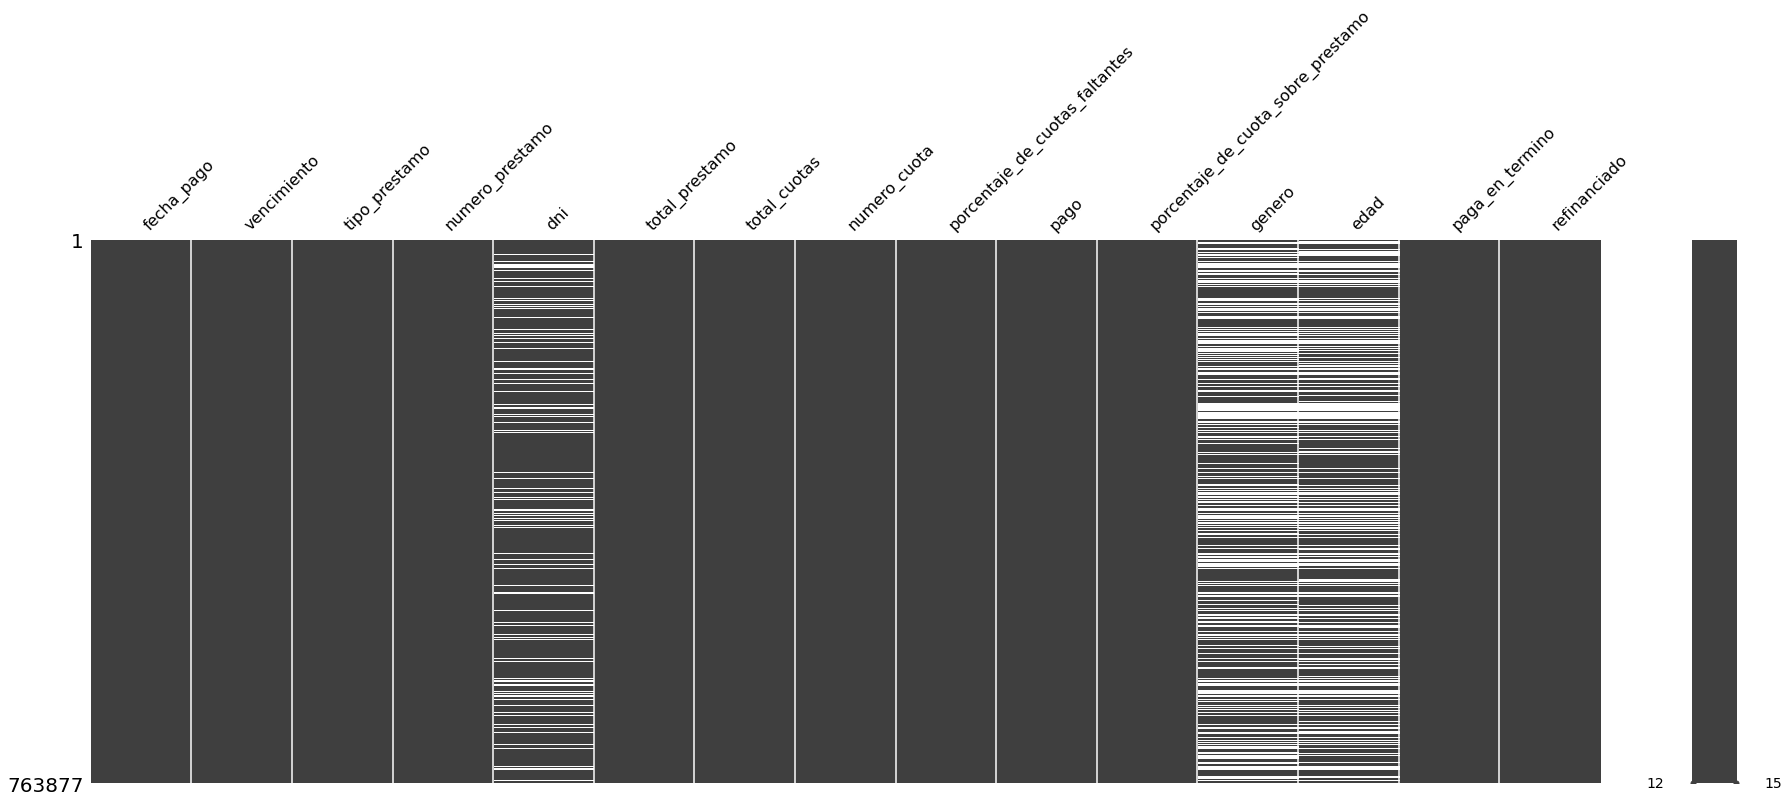

In [8]:
# Detectamos valores faltantes
msno.matrix(df, figsize=(30,10))

## Chequeo que para cada DNI exista una unica edad y genero

In [9]:
dni_df = df[['dni', 'edad', 'genero']]

In [10]:
dni_uniques = dni_df.groupby('dni')['edad','genero'].nunique()
dni_uniques.head(3)

,edad,genero
dni,,
2.0,0,0
9.0,1,1
29.0,1,1


In [11]:
# Obtengo los DNI que tengan mas de una edad o genero
dni_error = dni_uniques[(dni_uniques>1).any(axis=1)].index
dni_error

Float64Index([ 3073270.0,  4305479.0,  4954272.0,  4991124.0,  5087952.0,
               5124029.0,  5138405.0,  5201050.0,  5282162.0,  5570811.0,
               5594257.0,  5658001.0,  5665791.0,  6084686.0,  6147893.0,
               6245394.0,  6371629.0,  6519814.0,  6536437.0,  6652650.0,
               7162249.0,  7377515.0,  7704965.0,  8252165.0,  8326485.0,
               8400924.0,  8514256.0,  8633243.0, 10174146.0, 10758672.0,
              11241030.0, 11469042.0, 11768623.0, 12702446.0, 12712566.0,
              13285676.0, 14317845.0, 16051677.0, 16315055.0, 16938614.0,
              17046748.0, 17187923.0, 17283305.0, 17563244.0, 17614252.0,
              18328611.0, 18387076.0, 18404973.0, 18652869.0, 20351439.0,
              20389809.0, 20986191.0, 21640157.0, 24905162.0, 25228398.0,
              92028416.0, 92089425.0, 92099674.0, 92244256.0, 92452663.0,
              92640824.0, 92676137.0, 92840561.0, 92903683.0, 92940304.0,
              92947290.0, 92950018.0, 

In [12]:
df_1_sin_dni_error = df[~df['dni'].isin(dni_error)].copy()

### Genero y edad 

In [13]:
# Separado las columnas que no tienen problemas de las que si
columns_problem = ['genero', 'edad']
columns_ok = list(set(df.columns) - set(columns_problem))

In [14]:
#  Chequeo filas duplicadas del dataset, habiendo sacado las columnas de genero y edad
df_1_sin_dni_error[columns_ok].duplicated().sum()

65590

In [15]:
# Mergeo las filas duplicadas remplazando los valores nulos de genero y edad // ver si las droppeo los prestamos
df_2_sin_dup =df_1_sin_dni_error.groupby(columns_ok)[columns_problem].first().reset_index()

In [16]:
# chequeo valores faltantes
dsimp.missing_values_table(df_2_sin_dup)

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
genero,142829,24.8
edad,121511,21.1


In [17]:
# ya no tengo filas duplicadas
df_2_sin_dup[columns_ok].duplicated().sum()

0

In [18]:
# separo los dni que tienen valores nulos
dni_gen_null = df_2_sin_dup.loc[df_2_sin_dup['genero'].isnull(), 'dni']
dni_edad_null = df_2_sin_dup.loc[df_2_sin_dup['edad'].isnull(), 'dni']

### Busco completar el genero que sigue en NAN

In [19]:
# trato de ver si puedo traer el genero del dni
df.loc[(df['dni'].isin(dni_gen_null)) & (~df['genero'].isnull())]

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado


### Busco completar la edad que sigue en NAN

In [20]:
# trato de ver si puedo traer la edad del los dni faltantes buscandolos en el dataset  original
df.loc[(df['dni'].isin(dni_edad_null)) & (~df['edad'].isnull())]

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado


In [21]:
# No puedo completar las filas asi que las saco
df_3_sin_nan = df_2_sin_dup.dropna()

In [22]:
# chequeo valores faltantes
dsimp.missing_values_table(df_3_sin_nan)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# 3. DATA FORMATING

In [23]:
df_4_parsed = df_3_sin_nan.copy()

In [24]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 0 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   fecha_pago                          395516 non-null  object 
 1   total_cuotas                        395516 non-null  int64  
 2   numero_cuota                        395516 non-null  int64  
 3   dni                                 395516 non-null  float64
 4   pago                                395516 non-null  object 
 5   porcentaje_de_cuota_sobre_prestamo  395516 non-null  object 
 6   refinanciado                        395516 non-null  int64  
 7   numero_prestamo                     395516 non-null  int64  
 8   total_prestamo                      395516 non-null  object 
 9   tipo_prestamo                       395516 non-null  int64  
 10  porcentaje_de_cuotas_faltantes      395516 non-null  object 
 11  vencimiento               

 ### Análisis de los tipo de de columna

In [25]:
# Columnas que son de tipo objeto
df_4_parsed.select_dtypes(include="object").columns

Index(['fecha_pago', 'pago', 'porcentaje_de_cuota_sobre_prestamo',
       'total_prestamo', 'porcentaje_de_cuotas_faltantes', 'vencimiento',
       'genero'],
      dtype='object')

In [26]:
# Columnas que son de tipo float
df_4_parsed.select_dtypes(include="float").columns

Index(['dni', 'edad'], dtype='object')

In [27]:
# Columnas que son de tipo int
df_4_parsed.select_dtypes(include="int").columns

Index([], dtype='object')

### Parseo de columnas str a float

In [28]:
# Parceo a tipo float
columns_to_float = ['pago', 'total_prestamo', 'porcentaje_de_cuotas_faltantes',  'porcentaje_de_cuota_sobre_prestamo']
for column in columns_to_float:
    df_4_parsed[column] = df_3_sin_nan[column].str.replace(',','.').astype('float')

In [29]:
df_4_parsed[columns_to_float].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 0 to 575915
Data columns (total 4 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   pago                                395516 non-null  float64
 1   total_prestamo                      395516 non-null  float64
 2   porcentaje_de_cuotas_faltantes      395516 non-null  float64
 3   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64
dtypes: float64(4)
memory usage: 15.1 MB


In [30]:
df_4_parsed[columns_to_float].describe().apply(lambda col: col.apply('{0:.5f}'.format))

,pago,total_prestamo,porcentaje_de_cuotas_faltantes,porcentaje_de_cuota_sobre_prestamo
count,395516.00000,395516.00000,395516.00000,395516.00000
mean,5613.99243,207312.16066,0.69413,0.75141
std,122692.01370,439371.30052,0.21966,4.72712
min,1.01000,94.74000,0.00000,0.00000
25%,58.04000,20001.68000,0.59000,0.23000
50%,201.81000,66939.97000,0.72000,0.30000
75%,453.00000,152827.93000,0.86000,0.40000
max,6680660.81000,7951994.75000,1.00000,105.56000


### Parseo de columnas str a date

In [31]:
# Se convierten las columnas de tipo object a tipo date 
columns_to_dates = ['fecha_pago', 'vencimiento']
df_4_parsed[columns_to_dates] =df_4_parsed[columns_to_dates].astype('datetime64[ns]')

### Formato final

In [32]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 0 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   fecha_pago                          395516 non-null  datetime64[ns]
 1   total_cuotas                        395516 non-null  int64         
 2   numero_cuota                        395516 non-null  int64         
 3   dni                                 395516 non-null  float64       
 4   pago                                395516 non-null  float64       
 5   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64       
 6   refinanciado                        395516 non-null  int64         
 7   numero_prestamo                     395516 non-null  int64         
 8   total_prestamo                      395516 non-null  float64       
 9   tipo_prestamo                       395516 non-null  int64         
 10  porcenta

# 4. EDA

## Analisis variable objetivo

Primero se inicia analizando la variable target para analizar si se encuentra balanceado el data set. Observamos que sigue una distribución uniforme, con lo cual no vamos a necesitar recurrir a SMOTE para balancearlo. Concluimos que:

* El dataset se encuentra balanceado
* No se observa presencia de anomalias o outliers

Text(0.5, 1.0, 'Balance de la variable objetivo "Paga_en_Termino"')

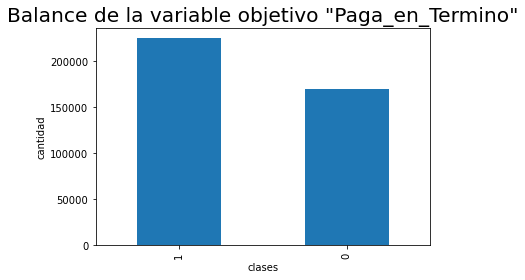

In [33]:
# Grafico
df_4_parsed['paga_en_termino'].value_counts().plot(kind='bar')
# Seteos del gráfico
plt.style.use('fivethirtyeight')
plt.xlabel('clases')
plt.ylabel ('cantidad')
plt.title('Balance de la variable objetivo "Paga_en_Termino"')

## Análisis de variables  

In [34]:
df_4_parsed.columns

Index(['fecha_pago', 'total_cuotas', 'numero_cuota', 'dni', 'pago',
       'porcentaje_de_cuota_sobre_prestamo', 'refinanciado', 'numero_prestamo',
       'total_prestamo', 'tipo_prestamo', 'porcentaje_de_cuotas_faltantes',
       'vencimiento', 'paga_en_termino', 'genero', 'edad'],
      dtype='object')

In [35]:
columns_data = ['total_cuotas', 'fecha_pago', 'numero_cuota', 'refinanciado', 'tipo_prestamo', 'pago', 'vencimiento',
                'total_prestamo','porcentaje_de_cuota_sobre_prestamo', 'paga_en_termino', 'porcentaje_de_cuotas_faltantes',  
               'genero', 'edad']

In [36]:
df_4_parsed.describe(include='all')

,fecha_pago,total_cuotas,numero_cuota,dni,pago,porcentaje_de_cuota_sobre_prestamo,refinanciado,numero_prestamo,total_prestamo,tipo_prestamo,porcentaje_de_cuotas_faltantes,vencimiento,paga_en_termino,genero,edad
count,395516,395516.000000,395516.000000,3.955160e+05,3.955160e+05,395516.000000,395516.000000,3.955160e+05,3.955160e+05,395516.000000,395516.000000,395516,395516.000000,395516,395516.000000
unique,1722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,920,NaN,2,NaN
top,2018-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-20 00:00:00,NaN,Masculino,NaN
freq,2062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6413,NaN,214486,NaN
first,2015-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-09-22 00:00:00,NaN,NaN,NaN
last,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-11-20 00:00:00,NaN,NaN,NaN
mean,NaN,277.117313,76.516356,2.854829e+07,5.613992e+03,0.751407,0.019236,7.231048e+06,2.073122e+05,738.070306,0.694132,NaN,0.569304,NaN,54.061196
std,NaN,115.460061,55.638796,2.798373e+07,1.226920e+05,4.727115,0.137352,4.739496e+06,4.393713e+05,334.205292,0.219655,NaN,0.495174,NaN,15.488148
min,NaN,1.000000,1.000000,9.000000e+00,1.010000e+00,0.000000,0.000000,1.070590e+05,9.474000e+01,1.000000,0.000000,NaN,0.000000,NaN,3.000000
25%,NaN,188.000000,27.000000,1.213174e+07,5.804000e+01,0.230000,0.000000,1.093507e+06,2.000168e+04,480.000000,0.590000,NaN,0.000000,NaN,43.000000


In [37]:
df_4_parsed.pago

0         422.07
1         220.04
2         220.04
7         119.98
18         90.01
           ...  
575908     48.37
575910     22.21
575911    156.74
575914    347.91
575915      1.34
Name: pago, Length: 395516, dtype: float64

<Figure size 432x288 with 0 Axes>

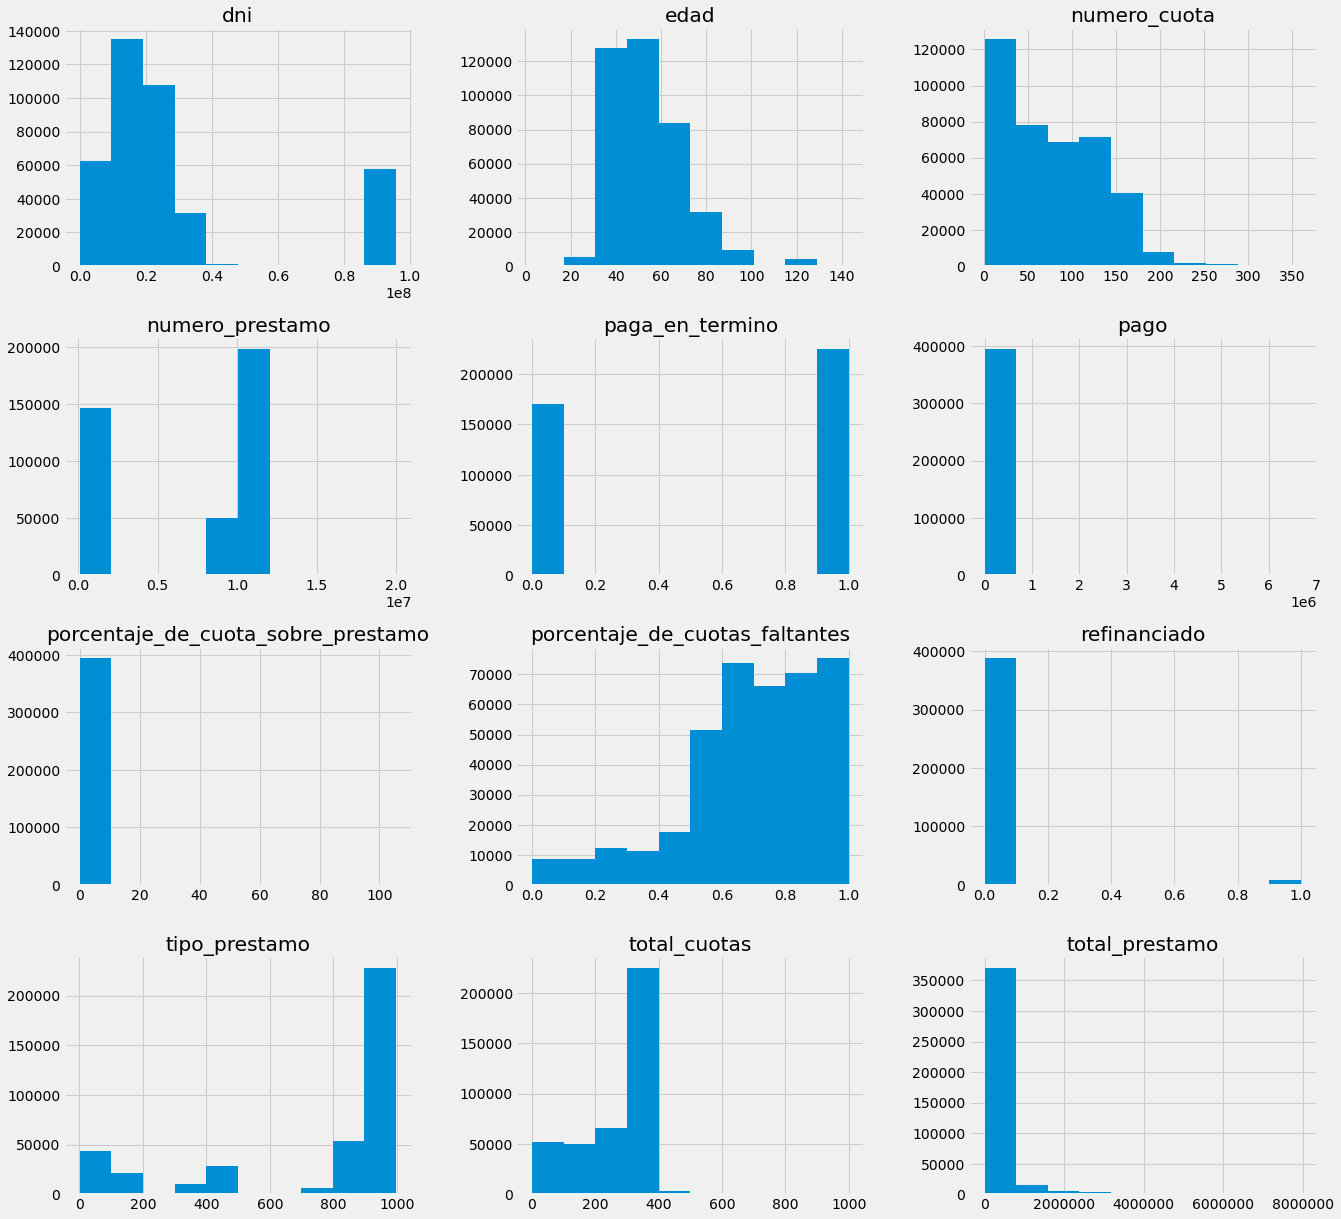

In [38]:
f = plt.figure() 
df_4_parsed.hist(figsize=(20,20))
plt.ticklabel_format(style='plain', axis='x')
plt.show()

### Total cuotas

<AxesSubplot:>

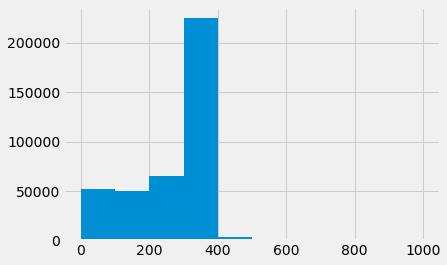

In [39]:
df_4_parsed['total_cuotas'].hist()

In [40]:
df_4_parsed['total_cuotas'].describe()

count    395516.000000
mean        277.117313
std         115.460061
min           1.000000
25%         188.000000
50%         360.000000
75%         360.000000
max         999.000000
Name: total_cuotas, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x11e5e82cb80>,
 'caps': [<matplotlib.lines.Line2D at 0x11e5e82c190>,
 'boxes': [<matplotlib.lines.Line2D at 0x11e5e82c610>],
 'medians': [<matplotlib.lines.Line2D at 0x11e5f26d0d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x11e5f26d4c0>],
 'means': []}

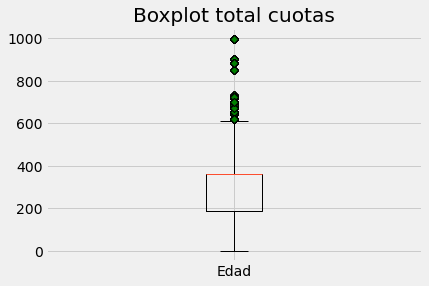

In [41]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot total cuotas')
ax.boxplot(df_4_parsed['total_cuotas'], flierprops=green_diamond, labels=["Edad"])

### Total prestamo

<AxesSubplot:>

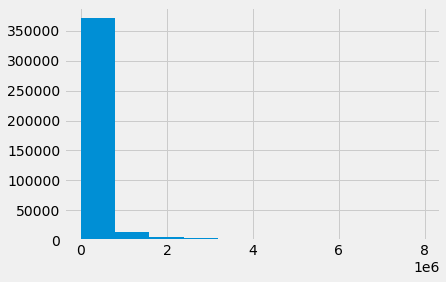

In [42]:
df_4_parsed['total_prestamo'].hist()

In [43]:
pd.options.display.float_format = '{:.1f}'.format
df_4_parsed['total_prestamo'].describe()

count    395516.0
mean     207312.2
std      439371.3
min          94.7
25%       20001.7
50%       66940.0
75%      152827.9
max     7951994.8
Name: total_prestamo, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x11e544f2370>,
 'caps': [<matplotlib.lines.Line2D at 0x11e544f2af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11e544f22e0>],
 'medians': [<matplotlib.lines.Line2D at 0x11e5f1bc400>],
 'fliers': [<matplotlib.lines.Line2D at 0x11e5f1bcb80>],
 'means': []}

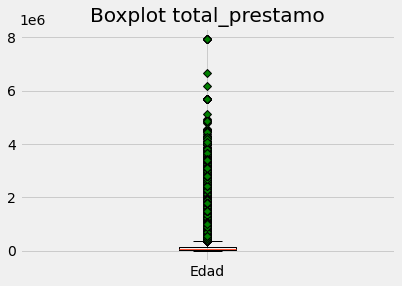

In [44]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot total_prestamo')
ax.boxplot(df_4_parsed['total_prestamo'], flierprops=green_diamond, labels=["Edad"])

TypeError: 'AxesSubplot' object is not callable

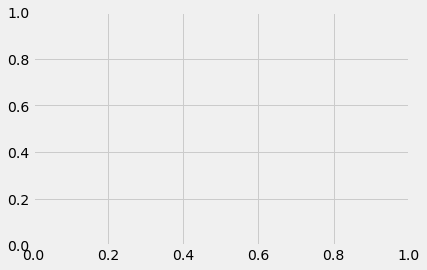

In [45]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax(figsize=(8, 8))
ax.set_title('Boxplot total_prestamo')
ax.ticklabel_format(useOffset=False)
ax.scatter(y= df_4_parsed['total_prestamo'], x=df_4_parsed['total_prestamo'].index)
ax.ticklabel_format(useOffset=False)
plt.plot()

------------------
----

In [46]:
from pyod.models.knn import KNN
import pandas as pd
 
edades = np.array([22,22,23,23,23,23,26,27,27,28,30,30,30,30,31,32,33,34,80])
edad_unique, counts = np.unique(edades, return_counts=True)
salario_anual_miles = np.array([16,20,15,21,19,17,33,22,31,32,56,30,22,31,30,16,2,22,23])
compras_mes = np.array([1,2,1,20,1,0,3,2,3,0,5,3,2,1,0,1,2,2,2])


X = pd.DataFrame(data={'edad':edades,'salario':salario_anual_miles, 'compras':compras_mes})
X

ModuleNotFoundError: No module named 'pyod'

In [47]:
clf = KNN(contamination=0.18)
clf.fit(X)
y_pred = clf.predict(X)
X[y_pred == 1]

NameError: name 'KNN' is not defined

--------
-------

## Distribución de prestamos entre mujeres, hombres y edades 

In [46]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 0 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   fecha_pago                          395516 non-null  datetime64[ns]
 1   total_cuotas                        395516 non-null  int64         
 2   numero_cuota                        395516 non-null  int64         
 3   dni                                 395516 non-null  float64       
 4   pago                                395516 non-null  float64       
 5   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64       
 6   refinanciado                        395516 non-null  int64         
 7   numero_prestamo                     395516 non-null  int64         
 8   total_prestamo                      395516 non-null  float64       
 9   tipo_prestamo                       395516 non-null  int64         
 10  porcenta

In [47]:
df_prestamos = df_4_parsed[['numero_prestamo', 'edad', 'genero']]
df_prestamos = df_prestamos.drop_duplicates()
df_prestamos.groupby(['genero','edad']).count().reset_index()['numero_prestamo'].sum()

10386

### Corr 

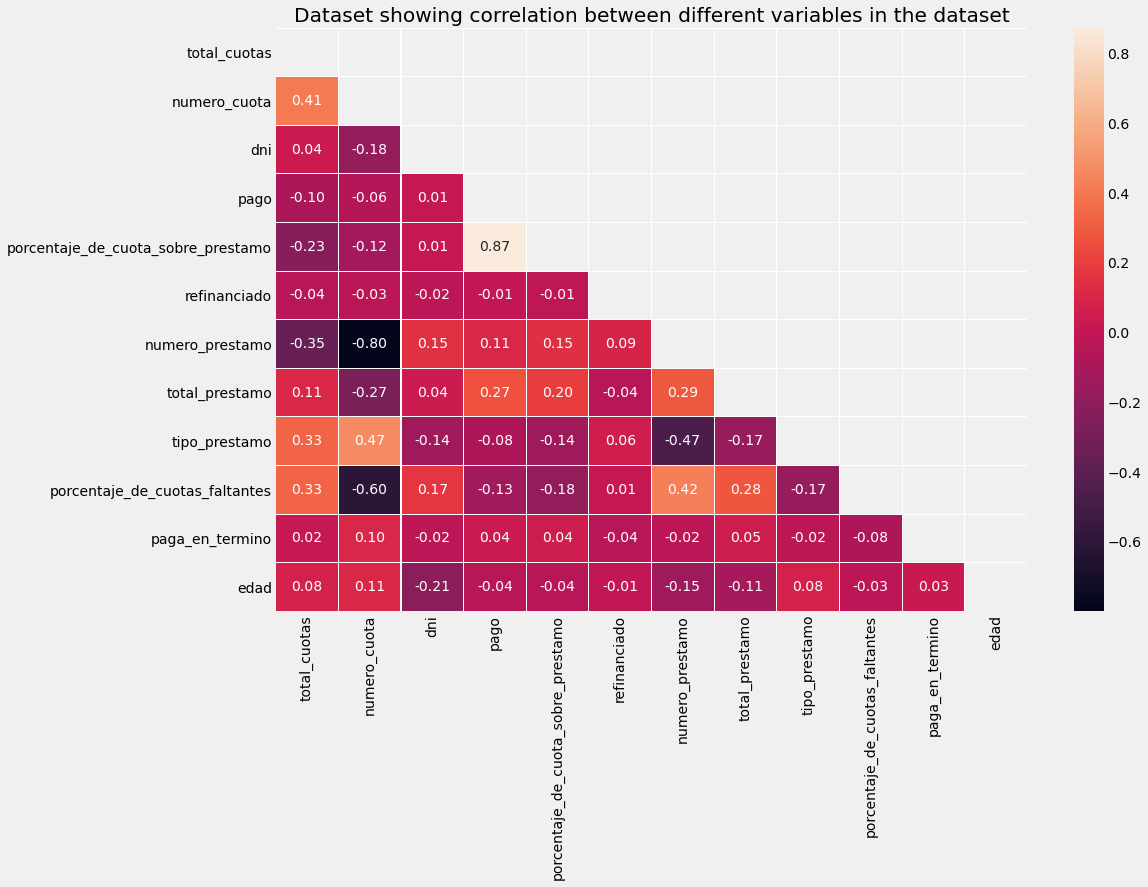

In [48]:
corr = df_4_parsed.corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.2, mask=mask)
plt.title('Dataset showing correlation between different variables in the dataset')
plt.show()

In [49]:
price_range_corr =  corr.paga_en_termino.sort_values(ascending = False)
price_range_corr_top = price_range_corr.head(10)
price_range_corr_bottom = price_range_corr.tail(10)
print ('top corr: \n{} \n\nbottom corr: \n{}'.format(price_range_corr_top, price_range_corr_bottom))

top corr: 
paga_en_termino                       1.0
numero_cuota                          0.1
total_prestamo                        0.0
porcentaje_de_cuota_sobre_prestamo    0.0
pago                                  0.0
edad                                  0.0
total_cuotas                          0.0
tipo_prestamo                        -0.0
dni                                  -0.0
numero_prestamo                      -0.0
Name: paga_en_termino, dtype: float64 

bottom corr: 
total_prestamo                        0.0
porcentaje_de_cuota_sobre_prestamo    0.0
pago                                  0.0
edad                                  0.0
total_cuotas                          0.0
tipo_prestamo                        -0.0
dni                                  -0.0
numero_prestamo                      -0.0
refinanciado                         -0.0
porcentaje_de_cuotas_faltantes       -0.1
Name: paga_en_termino, dtype: float64


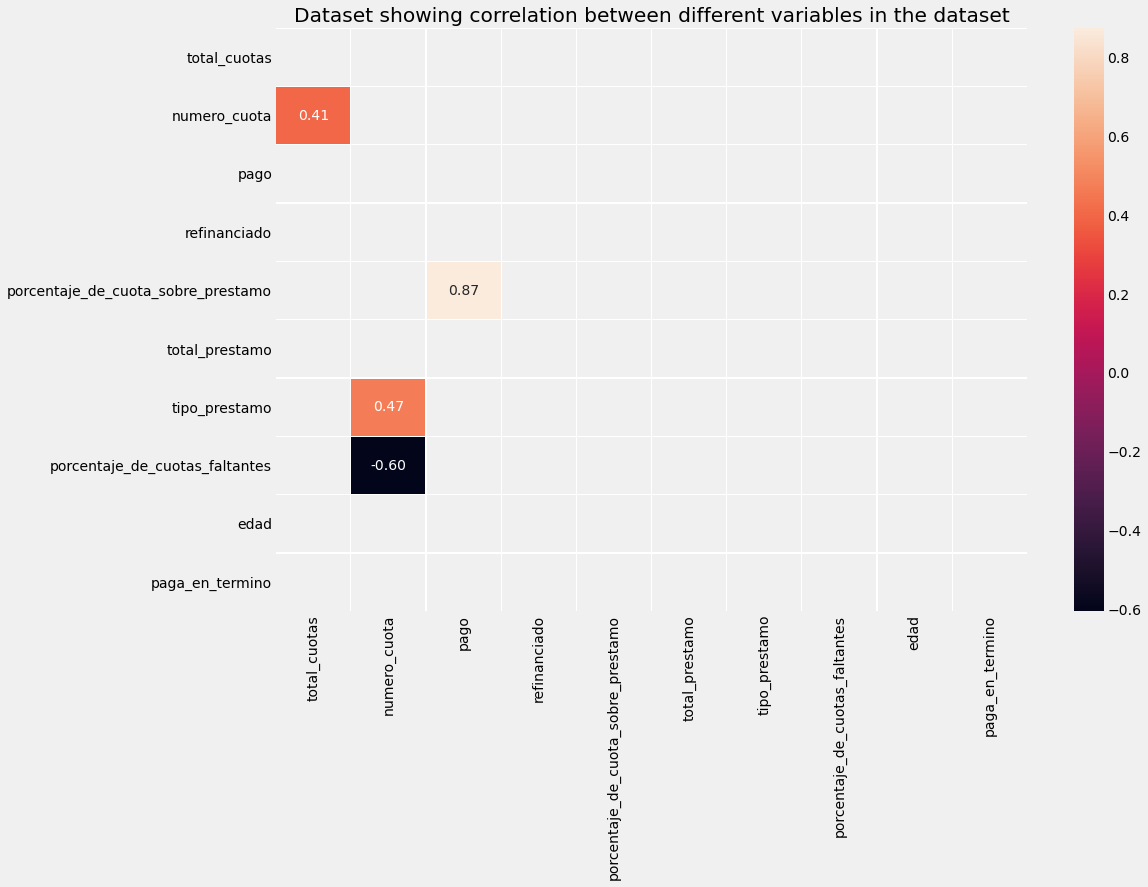

In [50]:
columns_data_corr = list(set(columns_data)&set(corr.columns))
corr_filter = corr[(corr>0.4) | (corr<-0.4)][columns_data_corr].copy()
corr_filter = corr_filter.filter(items = columns_data_corr, axis=0)
mask = np.triu(np.ones_like(corr_filter))
corr_filter.shape

plt.figure(figsize=(15,10))
sns.heatmap(corr_filter, annot=True, fmt='.2f', linewidths=.2,mask=mask)
plt.title('Dataset showing correlation between different variables in the dataset')
plt.show()

### Limpio los outliers principales 

In [51]:
df_4_parsed['total_prestamo']

0        165771.4
1          4203.8
2          4195.0
7          4218.6
18         4640.3
           ...   
575908    15585.6
575910    57026.9
575911    57026.9
575914   150472.2
575915   150472.2
Name: total_prestamo, Length: 395516, dtype: float64

In [52]:
df_4_parsed['genero'] = df_4_parsed['genero'].str.lower().replace(['femenino','masculino'],[0,1])

In [53]:
Q1 = df_4_parsed['total_prestamo'].quantile(0.25)
Q3 = df_4_parsed['total_prestamo'].quantile(0.75)
IQR = Q3 - Q1
IQR

132826.25

In [54]:
from scipy import stats
z = np.abs(stats.zscore(df_4_parsed['total_prestamo']))
z

array([0.09454596, 0.46227097, 0.46229104, ..., 0.34204649, 0.12936678,
       0.12936678])

In [55]:
index_no_outlier = df_4_parsed['total_prestamo'][(z < 2)].index

In [56]:
index_no_outlier

Int64Index([     0,      1,      2,      7,     18,     20,     21,     22,
                23,     24,
            ...
            575903, 575904, 575905, 575906, 575907, 575908, 575910, 575911,
            575914, 575915],
           dtype='int64', length=379746)

In [57]:
prestamos_sin_outlier = df.filter(items = index_no_outlier, axis=0)['numero_prestamo'].unique()

In [58]:
df_5_sin_outlier = df_4_parsed[df_4_parsed['numero_prestamo'].isin(prestamos_sin_outlier)].copy()

## Pipeline de modelos para elegir el mejor modelo para poder predecir

In [72]:
from sklearn.model_selection import train_test_split
y = df_5_sin_outlier['paga_en_termino']
X = df_5_sin_outlier[list(set(columns_data)-  {'paga_en_termino','fecha_pago', 'vencimiento','dni','numero_prestamo','pago'})]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [ ]:
pipelines = []

pipelines.append(('ScaledCART', Pipeline([('Scaler', RobustScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledRFR', Pipeline([('Scaler', RobustScaler()),('RFR', RandomForestRegressor(max_depth = 5))])))
pipelines.append(('ScaledLR', Pipeline([('Scaler', RobustScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', RobustScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', RobustScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', RobustScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', RobustScaler()),('GBM', GradientBoostingRegressor())])))


results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=5, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledCART: -0.123252 (0.001886)
ScaledRFR: -0.213023 (0.000564)
ScaledLR: -0.238617 (0.000354)
ScaledLASSO: -0.244985 (0.000070)
ScaledEN: -0.244985 (0.000070)
ScaledKNN: -0.127685 (0.000641)
ScaledGBM: -0.199548 (0.000581)


## MODELADO 

In [61]:
df.columns

Index(['fecha_pago', 'vencimiento', 'tipo_prestamo', 'numero_prestamo', 'dni',
       'total_prestamo', 'total_cuotas', 'numero_cuota',
       'porcentaje_de_cuotas_faltantes', 'pago',
       'porcentaje_de_cuota_sobre_prestamo', 'genero', 'edad',
       'paga_en_termino', 'refinanciado'],
      dtype='object')

In [62]:
columns_data

['total_cuotas',
 'fecha_pago',
 'numero_cuota',
 'refinanciado',
 'tipo_prestamo',
 'pago',
 'vencimiento',
 'total_prestamo',
 'porcentaje_de_cuota_sobre_prestamo',
 'paga_en_termino',
 'porcentaje_de_cuotas_faltantes',
 'genero',
 'edad']

## Linear Regression

In [89]:
# Se instancia el modelo
lr = LinearRegression()
# Se fitea el modelo
lr.fit(X_train, y_train)
# Se evalua el modelo
lr_Range = lr.predict(X_test)
lr_Score = lr.score(X_test, y_test)
lr_Mae = mean_absolute_error(y_test, lr_Range)
print('score RL: ', lr_Score)
print('promedio de error absoluto RL', lr_Mae)

score RL:  0.02467735734861698
promedio de error absoluto RL 0.4772949195931153


## Random Forest

In [73]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8854356567779977


-----------

# COSAS CAMI 

* Sacar el tipo de prestamo porque el random forest busca si es mayor o menor a un numero

In [60]:
df_5_sin_outlier.columns

Index(['fecha_pago', 'total_cuotas', 'numero_cuota', 'dni', 'pago',
       'porcentaje_de_cuota_sobre_prestamo', 'refinanciado', 'numero_prestamo',
       'total_prestamo', 'tipo_prestamo', 'porcentaje_de_cuotas_faltantes',
       'vencimiento', 'paga_en_termino', 'genero', 'edad'],
      dtype='object')

In [61]:
df_5_sin_outlier['month_fp'] = df_5_sin_outlier['fecha_pago'].dt.month 
df_5_sin_outlier['year_fp'] = df_5_sin_outlier['fecha_pago'].dt.year 

In [63]:
sorted(df_5_sin_outlier['year_fp'].unique())

[2015, 2016, 2017, 2018, 2019]

In [79]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV



sorted(clf.cv_results_.keys())

features = list(set(columns_data)-  {'paga_en_termino','fecha_pago', 'vencimiento','dni','numero_prestamo','pago'})

res = []
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

for anio in [2015, 2016, 2017, 2018, 2019]:
    for mes in range (1,13):
        df_4_train = df_4_parsed.loc[(df_4_parsed['year_fp']<=anio) & (df_4_parsed['month_fp']<=mes), :]
        df_4_test  = df_4_parsed.loc[(df_4_parsed['year_fp']==anio) & (df_4_parsed['month_fp']==mes+1),: ]
        
        X_train = df_4_train[features]
        y_train = df_4_train['paga_en_termino']
        
        X_test = df_4_test[features]
        y_test = df_4_test['paga_en_termino']    
        
#         USAR GRID SEARCH ACA
        parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
        svc = svm.SVC()
        clf = GridSearchCV(svc, parameters)
        clf.fit(iris.data, iris.target)
        
        clf.fit(X_train,y_train)
        
        y_pred=clf.predict(X_test)
        
        print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
        
        res.append(metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8854356567779977
Accuracy: 0.7402924861321231
Accuracy: 0.7507583417593529
Accuracy: 0.7804992382514943
Accuracy: 0.7970632530120482
Accuracy: 0.8055822906641001
Accuracy: 0.8096280087527352
Accuracy: 0.8112457778660839
Accuracy: 0.8016832110487699
Accuracy: 0.8364580023302616
Accuracy: 0.8436363636363636
Accuracy: 0.8095744680851064


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required.

In [65]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)

features = list(set(columns_data)-  {'paga_en_termino','fecha_pago', 'vencimiento','dni','numero_prestamo','pago', 'tipo_prestamo'})

res = []
from sklearn import metrics

for anio in [2015, 2016, 2017, 2018, 2019]:
    for mes in range (1,13):
        df_4_train = df_5_sin_outlier.loc[(df_5_sin_outlier['year_fp']<=anio) & (df_5_sin_outlier['month_fp']<=mes), :].copy()
        df_4_test  = df_5_sin_outlier.loc[(df_5_sin_outlier['year_fp']==anio) & (df_5_sin_outlier['month_fp']==mes+1),: ].copy()
        
        X_train = df_4_train[features]
        y_train = df_4_train['paga_en_termino']
        
        X_test = df_4_test[features]
        y_test = df_4_test['paga_en_termino']       
        
        clf.fit(X_train,y_train)
        
        y_pred=clf.predict(X_test)
        
        print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
        
        res.append(metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7362304194037392
Accuracy: 0.7436156763590392
Accuracy: 0.7701149425287356
Accuracy: 0.7883239171374764
Accuracy: 0.7968780111774908
Accuracy: 0.7931411893469537
Accuracy: 0.7831013916500994
Accuracy: 0.7886442141623489
Accuracy: 0.8227754237288135
Accuracy: 0.8172062568206621
Accuracy: 0.7977288857345636


ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required.

In [66]:
df_5_sin_outlier[features]

,total_cuotas,genero,numero_cuota,porcentaje_de_cuota_sobre_prestamo,refinanciado,total_prestamo,edad,porcentaje_de_cuotas_faltantes
0,360,0,66,0.2,0,165771.4,47.0,0.8
1,20,0,3,5.2,0,4203.8,79.0,0.8
2,20,0,6,5.2,0,4195.0,65.0,0.7
7,38,0,6,2.8,0,4218.6,50.0,0.8
18,58,1,56,1.9,0,4640.3,87.0,0.0
...,...,...,...,...,...,...,...,...
575908,360,0,161,0.3,0,15585.6,68.0,0.6
575910,360,1,168,0.0,0,57026.9,121.0,0.5
575911,360,1,169,0.3,0,57026.9,121.0,0.5
575914,360,1,187,0.2,0,150472.2,43.0,0.5


-------

In [120]:
clf.feature_importances_


array([0.23581233, 0.05960475, 0.10517046, 0.17142813, 0.20890368,
       0.069803  , 0.12817068, 0.00218618, 0.01892079])

In [140]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [143]:
import time
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.248 seconds


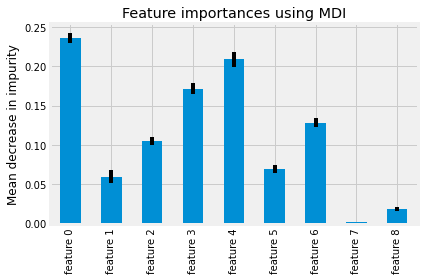

In [144]:


forest_importances = pd.Series(clf.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [151]:

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

     #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES') 


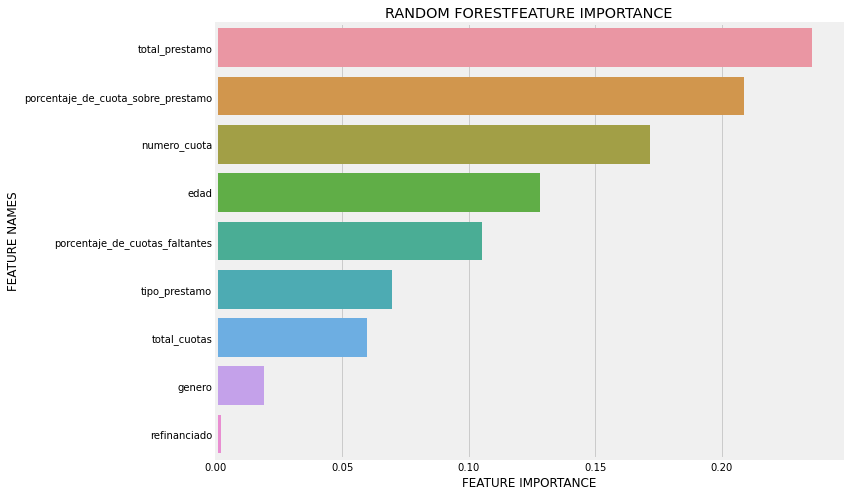

In [153]:
plot_feature_importance(clf.feature_importances_,X_train.columns,'RANDOM FOREST') 

## KNeighborsRegressor

In [78]:
# Se instancia el modelo
knn = KNeighborsClassifier(n_neighbors=4)
# Se fitea el modelo
knn.fit(X_train, y_train)
# Se predice el modelo
knn_range = knn.predict(X_test)
# Se evalua el modelo
knn_score = knn.score(X_test,y_test)
knn_mae = mean_absolute_error(y_test, knn_range)
print('score KNN: ', knn_score)
print('promedio de error absoluto KNN', knn_mae)


score KNN:  0.8652728873239437
promedio de error absoluto KNN 0.13472711267605633


In [70]:
error_rate = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

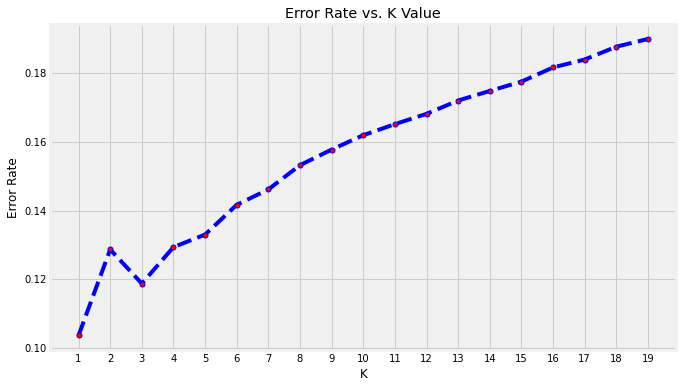

In [71]:
plt.figure(figsize=(10,6))
plt.xticks([x for x in range(21)])
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

## Decision Tree Classifier

In [116]:
# Se instancia el modelo
dtc = DecisionTreeClassifier(max_leaf_nodes=200,random_state = 1)
# Se fitea el modelo
dtc.fit(X_train, y_train)
# Se predice el modelo
dtc_range = dtc.predict(X_test)
# Se evalua el modelo
dtc_score = dtc.score(X_test, y_test)
dtc_mae = mean_absolute_error(y_test, dtc_range)
print('score DT: ', dtc_score)
print('promedio de error absoluto DT', dtc_mae)
importancia_features = pd.DataFrame(dt.feature_importances_, index = X.columns, columns=['importancia'])
importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)
importancia_features_sort[0:5]


score DT:  0.7251408450704225
promedio de error absoluto DT 0.27485915492957746


,importancia
porcentaje_de_cuota_sobre_prestamo,0.4
total_prestamo,0.2
total_cuotas,0.2
tipo_prestamo,0.1
numero_cuota,0.1


In [ ]:
plt.figure(figsize=(10,5))
tree.plot_tree(dt,feature_names=df.columns[:-1],filled=True,rounded=True, fontsize=12)
plt.show()

### Decision Tree Regression

In [93]:
# Se instancia el modelo
dt = DecisionTreeRegressor(max_leaf_nodes=200, random_state = 1)
# Se fitea el modelo
dt.fit(X_train, y_train)
# Prediccion
dt_range = dt.predict(X_test)
# Evaluación del modelo
dt_score = dt.score(X_test, y_test)
dt_Mae = mean_absolute_error(y_test, dt_range)
print('score DT: ', dt_score)
print('promedio de error absoluto DT', dt_Mae)

score DT:  0.24563199108051725
promedio de error absoluto DT 0.36751227808564313


In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)

X_test_scl = scaler.transform(X_test)

In [96]:
model_1 = GaussianNB()
fit_1 = model_1.fit(X_train_scl, y_train)

In [97]:
predict_1_cat = fit_1.predict(X_test_scl)
accuracy_1 = accuracy_score(y_test, predict_1_cat)
print(accuracy_1)
conf_mat_1 = confusion_matrix(y_test, predict_1_cat)
print(conf_mat_1)

0.5713380281690141
[[25229 23255]
 [25441 39675]]


In [98]:
model_2 = KNeighborsClassifier()
fit_2 = model_2.fit(X_train_scl, y_train)

In [99]:
predict_2_cat = fit_2.predict(X_test_scl)
accuracy_2 = accuracy_score(y_test, predict_2_cat)
print(accuracy_2)
conf_mat_2 = confusion_matrix(y_test, predict_2_cat)
print(conf_mat_2)

0.7940492957746479
[[34514 13970]
 [ 9426 55690]]


In [100]:
model_3 = tree.DecisionTreeClassifier(criterion='gini')
fit_3 = model_3.fit(X_train_scl, y_train)

In [101]:
predict_3_cat = fit_3.predict(X_test_scl)
accuracy_3 = accuracy_score(y_test, predict_3_cat)
print(accuracy_3)
conf_mat_3 = confusion_matrix(y_test, predict_3_cat)
print(conf_mat_3)

0.8586443661971831
[[40053  8431]
 [ 7627 57489]]


In [111]:
import statistics
from statistics import mode
def predict_ensamble(X, model_1, model_2, model_3):
    y_pred_1 = model_1.predict(X)
    y_pred_2 = model_2.predict(X)
    y_pred_3 = model_3.predict(X)
    result_mode = mode([y_pred_1, y_pred_2, y_pred_3]).mode
    result = np.transpose(result_mode)    
    return result

In [113]:
predict_cat_ensemble = predict_ensamble(X_test_scl, fit_1, fit_2, fit_3)
accuracy_ensemble = accuracy_score(y_test, predict_cat_ensemble)
print(accuracy_ensemble)
#predict_cat_ensemble.shape
#conf_mat_ensemble = confusion_matrix(y_test, predict_cat_ensemble)
#print(conf_mat_ensemble)

TypeError: unhashable type: 'numpy.ndarray'